# Notebook for Convolutional Neural Network with Torchvision- Pytorch

### Imports & Installations

In [168]:
#pip install torchvision

In [189]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Class distribution

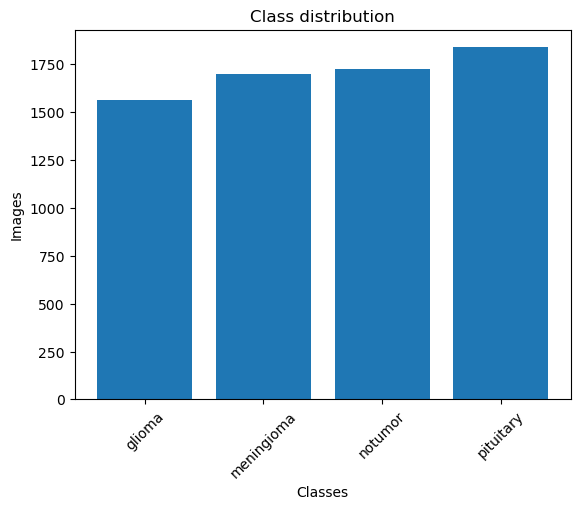

In [170]:
# Distribution of images per class in the training dataset 
labels_list = [label for _, label in train_dataset]
class_counts = Counter(labels_list)

plt.bar(train_dataset.classes, class_counts.values())
plt.title("Class distribution")
plt.xlabel("Classes")
plt.ylabel("Images")
plt.xticks(rotation=45)
plt.show()

### Image examples

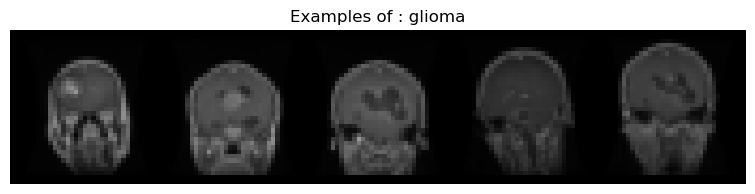

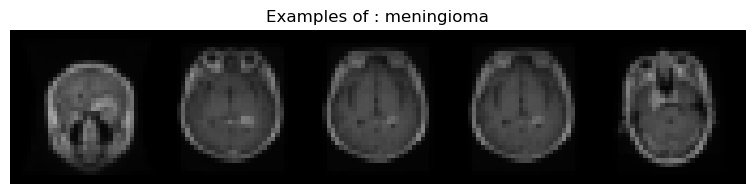

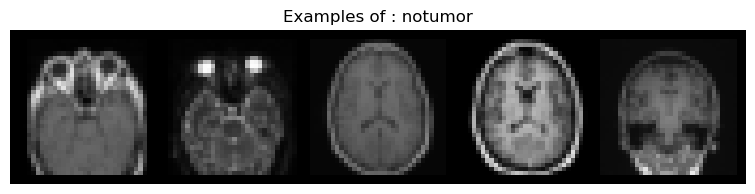

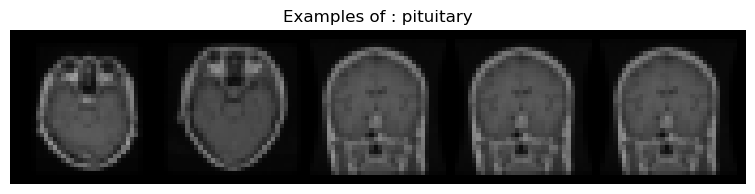

In [171]:
# EDA analysis dataset 
eda_transform = transforms.Compose([
    transforms.Grayscale(),       
    transforms.Resize((32, 32)),  
    transforms.ToTensor()
])

eda_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=eda_transform)

# Showing images function
def show_images_by_class(dataset, class_idx, n=5):
    imgs = [img for img, label in dataset if label == class_idx][:n]
    grid = torchvision.utils.make_grid(imgs, nrow=n, padding=2)
    npimg = grid.numpy()
    
    # Mostrar en escala de grises correctamente
    plt.figure(figsize=(10, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.title(f"Examples of : {dataset.classes[class_idx]}")
    plt.axis('off')
    plt.show()

# Showing n images
for i in range(len(eda_dataset.classes)):
    show_images_by_class(eda_dataset, i)

### Augmented examples 

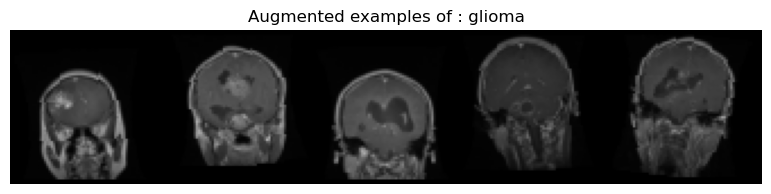

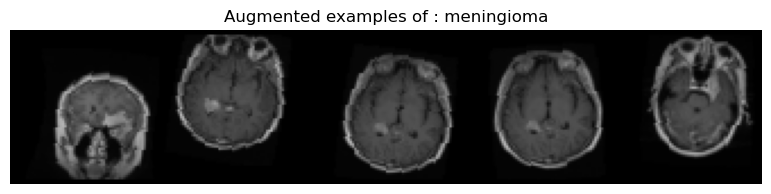

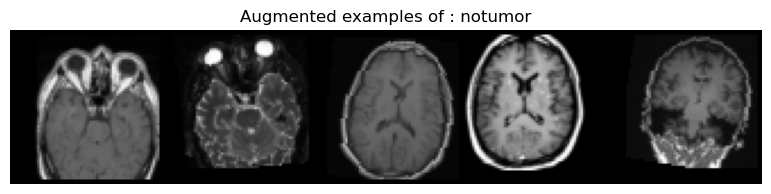

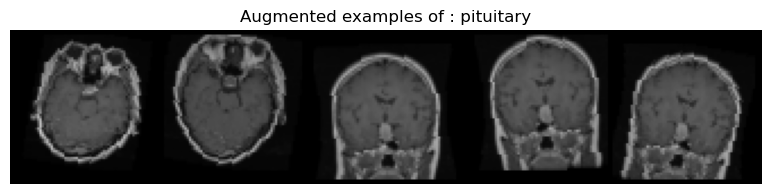

In [172]:
# Dataset with data augmentation
eda_augmented_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

eda_augmented_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=eda_augmented_transform)

# Plotting the classes with their respecting images 
def show_augmented_images_by_class(dataset, class_idx, n=5):
    imgs = [img for img, label in dataset if label == class_idx][:n]
    grid = torchvision.utils.make_grid(imgs, nrow=n, padding=2)
    npimg = grid.numpy()

    plt.figure(figsize=(10, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.title(f"Augmented examples of : {dataset.classes[class_idx]}")
    plt.axis('off')
    plt.show()

# Images per class
for i in range(len(eda_augmented_dataset.classes)):
    show_augmented_images_by_class(eda_augmented_dataset, i)


### Previous Transformations

In [173]:
# Transformations
training_transform = transforms.Compose([
    transforms.Grayscale(),                  # grayscale
    transforms.Resize((64, 64)),             # resizing the data
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),                   # converting to a tensor 
    transforms.Normalize((0.5,), (0.5,)),    # normalizing 
])

eval_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data route 
data_dir = "../Data"  

# Loading datasets 
training_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=training_transform)
trainval_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=eval_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "Testing"), transform=eval_transform)

train_size = int(0.8 * len(trainval_dataset))
val_size = len(training_dataset) - train_size

# Seed and random generated subsets
generator = torch.Generator().manual_seed(42)
train_subset, _ = random_split(training_dataset, [train_size, val_size], generator=generator)
_, val_subset = random_split(trainval_dataset, [train_size, val_size], generator=generator)


# Data loaders 
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Classes
print("Class list:", training_dataset.classes)

Class list: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Architecture of the network 

In [200]:
class Net(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Convoluciones
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)  

        
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 64, 64)  
            out = self.pool(F.relu(self.conv1(dummy)))
            out = self.pool(F.relu(self.conv2(out)))
            out = self.pool(F.relu(self.conv3(out)))
            flat_size = out.view(1, -1).shape[1]

        # Capas totalmente conectadas
        self.fc1 = nn.Linear(flat_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # → (B, 16, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))  # → (B, 32, 16, 16)
        x = self.pool(F.relu(self.conv3(x)))  
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))               # → (B, 128)
        x = F.relu(self.fc2(x))               # → (B, 64)
        x = self.fc3(x)                       # → (B, 4)
        return x


In [175]:
len(val_loader)

43

In [176]:
len(test_loader)

45

### Training Loop 

In [211]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(num_classes=4)
net.to(device)

# Definition of the loss function and optimizer 
weights = torch.tensor([1.5, 1.5, 1.0, 1.0], dtype=torch.float32).to(device) # Weights for glioma and meningioma increased
criterion = nn.CrossEntropyLoss(weight=weights)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Scheduler for LR
# scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


# Configuring Early Stopping for the training 
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(30):  # epochs
    net.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] Train Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # Validation
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total

    print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f} | Accuracy = {accuracy:.4f}")

    scheduler.step(avg_val_loss)
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Patience =  {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Loop stopped")
            break

print("Training finished")


[1,   100] Train Loss: 1.074
Epoch 1: Val Loss = 0.6889 | Accuracy = 0.7260
[2,   100] Train Loss: 0.728
Epoch 2: Val Loss = 0.6037 | Accuracy = 0.7978
[3,   100] Train Loss: 0.622
Epoch 3: Val Loss = 0.5820 | Accuracy = 0.8073
[4,   100] Train Loss: 0.566
Epoch 4: Val Loss = 0.4756 | Accuracy = 0.8330
[5,   100] Train Loss: 0.530
Epoch 5: Val Loss = 0.4590 | Accuracy = 0.8403
[6,   100] Train Loss: 0.487
Epoch 6: Val Loss = 0.4099 | Accuracy = 0.8623
[7,   100] Train Loss: 0.437
Epoch 7: Val Loss = 0.3783 | Accuracy = 0.8652
[8,   100] Train Loss: 0.406
Epoch 8: Val Loss = 0.3116 | Accuracy = 0.8864
[9,   100] Train Loss: 0.382
Epoch 9: Val Loss = 0.2980 | Accuracy = 0.8989
[10,   100] Train Loss: 0.347
Epoch 10: Val Loss = 0.2942 | Accuracy = 0.9055
[11,   100] Train Loss: 0.328
Epoch 11: Val Loss = 0.2430 | Accuracy = 0.9179
[12,   100] Train Loss: 0.275
Epoch 12: Val Loss = 0.2409 | Accuracy = 0.9216
[13,   100] Train Loss: 0.289
Epoch 13: Val Loss = 0.2238 | Accuracy = 0.9326
[14,

### Testing Phase

In [212]:
# Test Evaluation
net.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"\nFinal test evaluation:")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



Final test evaluation:
Test Loss: 0.2288
Test Accuracy: 0.9199


In [213]:
# Test results report 
net.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Imprimir reporte
print("Classification per class (test):")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Classification per class (test):
              precision    recall  f1-score   support

      glioma       0.98      0.80      0.88       310
  meningioma       0.85      0.85      0.85       306
     notumor       0.94      0.99      0.97       465
   pituitary       0.91      0.99      0.95       330

    accuracy                           0.92      1411
   macro avg       0.92      0.91      0.91      1411
weighted avg       0.92      0.92      0.92      1411



In [210]:
# To save the model

torch.save(net, "../Models/CNN_model_4.pth")

# To load the model 
# net = torch.load("CNN_model_1.pth")
# net.to(device)
# net.eval()
